In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import random

plt.style.use('ggplot')


In [ ]:
    lgb_params = {
        'boosting_type': model_type,
        'objective': objective,
        'metric': metrics,
        'use_missing' : True,
        'is_unbalance': True,
        'learning_rate': 0.05,
        'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
        'max_depth': 3,  # -1 means no limit
        'min_child_samples': 50,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'colsample_bytree': 0.7,
        'subsample': 0.95,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'min_child_weight': 0.05,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 20000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0.01,  # L1 regularization term on weights
        'reg_lambda': 0.1,  # L2 regularization term on weights
        'nthread': 40,
        'verbose': -1,
    }

In [108]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='binary_error', model_type='gbdt',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=50, categorical_features=None):
    
    lgb_params = {
        'boosting_type': model_type,
        'objective': objective,
        'metric': metrics,
        'use_missing' : True,
        'is_unbalance': True,
        'learning_rate': 0.05,
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': 3,  # -1 means no limit
        'min_child_samples': 50,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'colsample_bytree': 0.4,
        'subsample': 0.85,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'subsample_for_bin': 20000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0.01,  # L1 regularization term on weights
        'reg_lambda': 8,  # L2 regularization term on weights
        'nthread': 40,
        'verbose': -1,
    }
    lgb_params.update(params)
    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=verbose_eval, 
                     feval=feval)

    return bst1

def model_validation(train_df,val_df,predictors,target,params):
    categorical=[]
    for item in predictors:
        if (item in CATE_LIST):
            categorical.append(item)
            
    '''
    if (target == 'Normal'):
        params = {
            'scale_pos_weight' : 0.013,
        } 
    else:
        params = {
            'scale_pos_weight' : 99,
        }
    '''
    bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        model_type='gbdt',
                        objective='binary', 
                        #metrics ='binary',
                        metrics={'auc'},
                        early_stopping_rounds=200, 
                        verbose_eval=50, 
                        num_boost_round=2000, 
                        categorical_features=categorical
                        )
    y_predict = bst.predict(val_df[predictors])
    if (target == 'Normal'):
        y_predict = 1 - y_predict
    atec_Score,b,c=atecml.data.accuracy_validation(val_df['Fraud'],y_predict)
    return bst,atec_Score

In [103]:
train_df = pd.read_pickle('./01_train.dat')
WOE_LIST = joblib.load('./woe_feature.dat')
CATE_LIST = WOE_LIST + atecml.data.CATE_FEATURE_LIST
#train_df = atecml.data.load_train()
#CATE_LIST = atecml.data.CATE_FEATURE_LIST


#drop unknown ?
train_df = train_df[train_df.label!=-1].reset_index(drop=True)
#unknown_indices = list(train_df[train_df.label==-1].index)
#train_df.loc[unknown_indices,'Fraud']=1

predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS2]
DateFold={}

DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-13').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-14',end_date='2017-09-22').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-23',end_date='2017-10-01').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-10-02',end_date='2017-10-12').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-13',end_date='2017-10-22').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-23',end_date='2017-11-24').index)

all_list = set(train_df.index) - set(DateFold[5])
len(all_list),len(DateFold[5])


(631141, 358865)

In [104]:
len(train_df[train_df['Fraud']==1])

12122

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.950963	valid's auc: 0.917639
[100]	train's auc: 0.958325	valid's auc: 0.925783
[150]	train's auc: 0.963639	valid's auc: 0.930686
[200]	train's auc: 0.966091	valid's auc: 0.935213
[250]	train's auc: 0.968749	valid's auc: 0.940307
[300]	train's auc: 0.973869	valid's auc: 0.951212
[350]	train's auc: 0.975633	valid's auc: 0.955749
[400]	train's auc: 0.978699	valid's auc: 0.962482
[450]	train's auc: 0.980531	valid's auc: 0.965831
[500]	train's auc: 0.981567	valid's auc: 0.96752
[550]	train's auc: 0.982263	valid's auc: 0.96852
[600]	train's auc: 0.982705	valid's auc: 0.96923
[650]	train's auc: 0.983226	valid's auc: 0.969783
[700]	train's auc: 0.983981	valid's auc: 0.970431
[750]	train's auc: 0.984399	valid's auc: 0.970666
[800]	train's auc: 0.984755	valid's auc: 0.971039
[850]	train's auc: 0.985233	valid's auc: 0.971509
[900]	train's auc: 0.985525	valid's auc: 0.971664
[950]	train

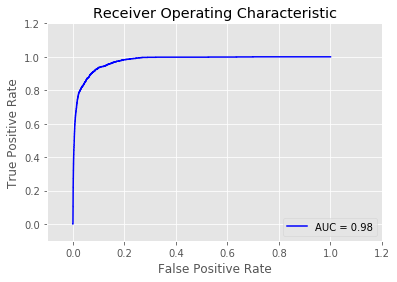

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.950909	valid's auc: 0.911554
[100]	train's auc: 0.958466	valid's auc: 0.925617
[150]	train's auc: 0.965071	valid's auc: 0.930715
[200]	train's auc: 0.967155	valid's auc: 0.937417
[250]	train's auc: 0.970852	valid's auc: 0.943886
[300]	train's auc: 0.974311	valid's auc: 0.952921
[350]	train's auc: 0.97566	valid's auc: 0.955352
[400]	train's auc: 0.979108	valid's auc: 0.961001
[450]	train's auc: 0.9819	valid's auc: 0.96558
[500]	train's auc: 0.982843	valid's auc: 0.966953
[550]	train's auc: 0.983945	valid's auc: 0.969369
[600]	train's auc: 0.984383	valid's auc: 0.970139
[650]	train's auc: 0.984637	valid's auc: 0.970226
[700]	train's auc: 0.984778	valid's auc: 0.970202
[750]	train's auc: 0.985285	valid's auc: 0.970721
[800]	train's auc: 0.985828	valid's auc: 0.971015
[850]	train's auc: 0.986271	valid's auc: 0.97143
[900]	train's auc: 0.986697	valid's auc: 0.971784
[950]	train's

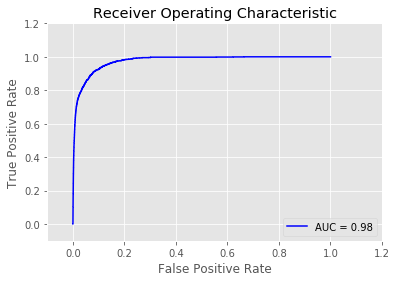

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.954197	valid's auc: 0.917746
[100]	train's auc: 0.964116	valid's auc: 0.929442
[150]	train's auc: 0.967068	valid's auc: 0.932067
[200]	train's auc: 0.969743	valid's auc: 0.937342
[250]	train's auc: 0.9723	valid's auc: 0.945025
[300]	train's auc: 0.97545	valid's auc: 0.951832
[350]	train's auc: 0.976835	valid's auc: 0.956334
[400]	train's auc: 0.979391	valid's auc: 0.961043
[450]	train's auc: 0.981839	valid's auc: 0.964731
[500]	train's auc: 0.983096	valid's auc: 0.966915
[550]	train's auc: 0.983548	valid's auc: 0.967479
[600]	train's auc: 0.983832	valid's auc: 0.96813
[650]	train's auc: 0.984401	valid's auc: 0.968793
[700]	train's auc: 0.984849	valid's auc: 0.969235
[750]	train's auc: 0.98528	valid's auc: 0.969438
[800]	train's auc: 0.98573	valid's auc: 0.970603
[850]	train's auc: 0.986176	valid's auc: 0.971155
[900]	train's auc: 0.986493	valid's auc: 0.971121
[950]	train's 

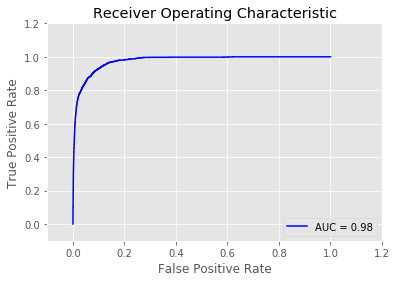

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.942246	valid's auc: 0.933243
[100]	train's auc: 0.954659	valid's auc: 0.949401
[150]	train's auc: 0.962389	valid's auc: 0.957301
[200]	train's auc: 0.963853	valid's auc: 0.96113
[250]	train's auc: 0.967639	valid's auc: 0.96467
[300]	train's auc: 0.971362	valid's auc: 0.96765
[350]	train's auc: 0.97592	valid's auc: 0.970692
[400]	train's auc: 0.978809	valid's auc: 0.973817
[450]	train's auc: 0.981275	valid's auc: 0.9759
[500]	train's auc: 0.982705	valid's auc: 0.976907
[550]	train's auc: 0.983617	valid's auc: 0.977605
[600]	train's auc: 0.983905	valid's auc: 0.977871
[650]	train's auc: 0.984459	valid's auc: 0.978331
[700]	train's auc: 0.984992	valid's auc: 0.97863
[750]	train's auc: 0.985712	valid's auc: 0.979055
[800]	train's auc: 0.986124	valid's auc: 0.979186
[850]	train's auc: 0.986593	valid's auc: 0.979419
[900]	train's auc: 0.987113	valid's auc: 0.979676
[950]	train's a

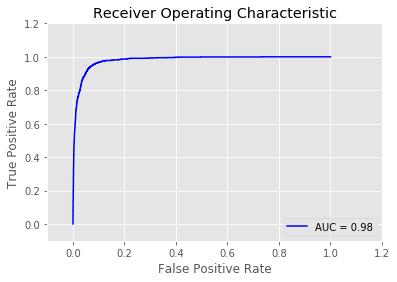

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.923004	valid's auc: 0.917712
[100]	train's auc: 0.94657	valid's auc: 0.941951
[150]	train's auc: 0.958846	valid's auc: 0.956521
[200]	train's auc: 0.961629	valid's auc: 0.961617
[250]	train's auc: 0.962632	valid's auc: 0.962807
[300]	train's auc: 0.972594	valid's auc: 0.969744
[350]	train's auc: 0.97507	valid's auc: 0.971806
[400]	train's auc: 0.978373	valid's auc: 0.974556
[450]	train's auc: 0.980743	valid's auc: 0.976208
[500]	train's auc: 0.981425	valid's auc: 0.977104
[550]	train's auc: 0.982497	valid's auc: 0.977716
[600]	train's auc: 0.983055	valid's auc: 0.977927
[650]	train's auc: 0.983536	valid's auc: 0.978107
[700]	train's auc: 0.983955	valid's auc: 0.978551
[750]	train's auc: 0.984227	valid's auc: 0.97892
[800]	train's auc: 0.984674	valid's auc: 0.97927
[850]	train's auc: 0.985153	valid's auc: 0.979652
[900]	train's auc: 0.985545	valid's auc: 0.979548
[950]	train'

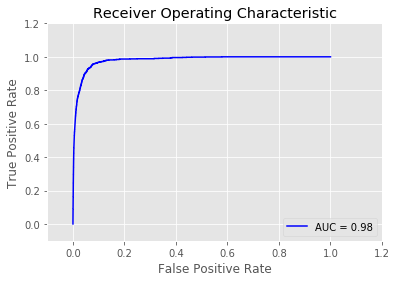

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.923229	valid's auc: 0.915579
[100]	train's auc: 0.954558	valid's auc: 0.948018
[150]	train's auc: 0.960133	valid's auc: 0.95485
[200]	train's auc: 0.962276	valid's auc: 0.958467
[250]	train's auc: 0.965082	valid's auc: 0.962528
[300]	train's auc: 0.971176	valid's auc: 0.966904
[350]	train's auc: 0.973915	valid's auc: 0.969221
[400]	train's auc: 0.976388	valid's auc: 0.972441
[450]	train's auc: 0.978564	valid's auc: 0.974318
[500]	train's auc: 0.979642	valid's auc: 0.975437
[550]	train's auc: 0.980572	valid's auc: 0.976161
[600]	train's auc: 0.981343	valid's auc: 0.976714
[650]	train's auc: 0.98231	valid's auc: 0.97741
[700]	train's auc: 0.982889	valid's auc: 0.977686
[750]	train's auc: 0.983692	valid's auc: 0.978392
[800]	train's auc: 0.984017	valid's auc: 0.978595
[850]	train's auc: 0.984478	valid's auc: 0.979072
[900]	train's auc: 0.985083	valid's auc: 0.979501
[950]	train

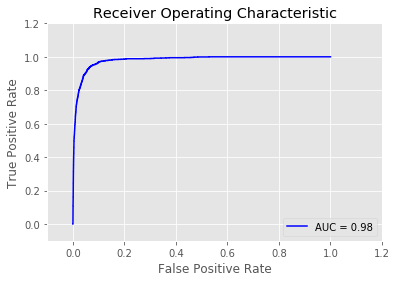

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.93957	valid's auc: 0.950414
[100]	train's auc: 0.951072	valid's auc: 0.962504
[150]	train's auc: 0.958242	valid's auc: 0.968821
[200]	train's auc: 0.961397	valid's auc: 0.970499
[250]	train's auc: 0.965073	valid's auc: 0.972145
[300]	train's auc: 0.971913	valid's auc: 0.974258
[350]	train's auc: 0.974506	valid's auc: 0.976109
[400]	train's auc: 0.978371	valid's auc: 0.977733
[450]	train's auc: 0.980348	valid's auc: 0.978974
[500]	train's auc: 0.981575	valid's auc: 0.97955
[550]	train's auc: 0.982298	valid's auc: 0.979843
[600]	train's auc: 0.982833	valid's auc: 0.980126
[650]	train's auc: 0.983421	valid's auc: 0.980355
[700]	train's auc: 0.98394	valid's auc: 0.980425
[750]	train's auc: 0.984545	valid's auc: 0.980808
[800]	train's auc: 0.984654	valid's auc: 0.980868
[850]	train's auc: 0.984996	valid's auc: 0.981016
[900]	train's auc: 0.985475	valid's auc: 0.981402
[950]	train

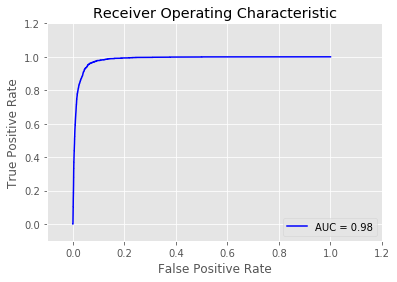

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.950594	valid's auc: 0.960189
[100]	train's auc: 0.95444	valid's auc: 0.962353
[150]	train's auc: 0.961087	valid's auc: 0.967986
[200]	train's auc: 0.963668	valid's auc: 0.969626
[250]	train's auc: 0.968547	valid's auc: 0.97091
[300]	train's auc: 0.97176	valid's auc: 0.972705
[350]	train's auc: 0.97532	valid's auc: 0.975868
[400]	train's auc: 0.978308	valid's auc: 0.977426
[450]	train's auc: 0.981019	valid's auc: 0.978634
[500]	train's auc: 0.98193	valid's auc: 0.979405
[550]	train's auc: 0.982679	valid's auc: 0.979822
[600]	train's auc: 0.983043	valid's auc: 0.97992
[650]	train's auc: 0.983458	valid's auc: 0.980117
[700]	train's auc: 0.983992	valid's auc: 0.980452
[750]	train's auc: 0.984423	valid's auc: 0.980542
[800]	train's auc: 0.984914	valid's auc: 0.980845
[850]	train's auc: 0.985405	valid's auc: 0.981105
[900]	train's auc: 0.985752	valid's auc: 0.981231
[950]	train's 

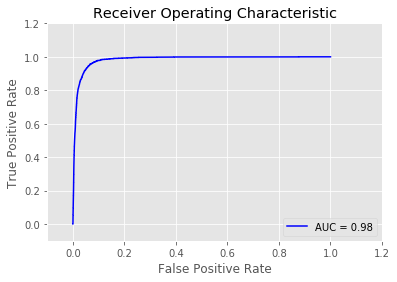

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.948818	valid's auc: 0.960817
[100]	train's auc: 0.951012	valid's auc: 0.962159
[150]	train's auc: 0.956101	valid's auc: 0.964753
[200]	train's auc: 0.958619	valid's auc: 0.966589
[250]	train's auc: 0.964986	valid's auc: 0.969206
[300]	train's auc: 0.971759	valid's auc: 0.974411
[350]	train's auc: 0.97439	valid's auc: 0.975594
[400]	train's auc: 0.977393	valid's auc: 0.977684
[450]	train's auc: 0.979656	valid's auc: 0.979292
[500]	train's auc: 0.980859	valid's auc: 0.979366
[550]	train's auc: 0.981896	valid's auc: 0.980162
[600]	train's auc: 0.982401	valid's auc: 0.980233
[650]	train's auc: 0.982876	valid's auc: 0.980612
[700]	train's auc: 0.98334	valid's auc: 0.980928
[750]	train's auc: 0.983794	valid's auc: 0.981094
[800]	train's auc: 0.984276	valid's auc: 0.981465
[850]	train's auc: 0.984783	valid's auc: 0.981714
[900]	train's auc: 0.985148	valid's auc: 0.981961
[950]	trai

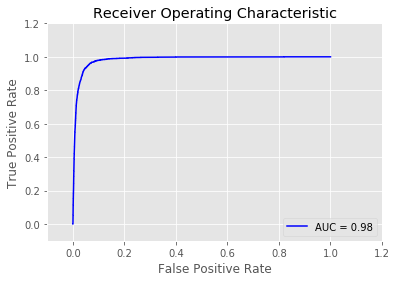

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.941973	valid's auc: 0.94766
[100]	train's auc: 0.95241	valid's auc: 0.954416
[150]	train's auc: 0.96053	valid's auc: 0.957168
[200]	train's auc: 0.96067	valid's auc: 0.957236
[250]	train's auc: 0.965915	valid's auc: 0.96192
[300]	train's auc: 0.972284	valid's auc: 0.968351
[350]	train's auc: 0.974961	valid's auc: 0.971099
[400]	train's auc: 0.978281	valid's auc: 0.974395
[450]	train's auc: 0.980315	valid's auc: 0.97614
[500]	train's auc: 0.981659	valid's auc: 0.976872
[550]	train's auc: 0.982475	valid's auc: 0.977367
[600]	train's auc: 0.982963	valid's auc: 0.977079
[650]	train's auc: 0.983769	valid's auc: 0.977507
[700]	train's auc: 0.984228	valid's auc: 0.977802
[750]	train's auc: 0.984681	valid's auc: 0.977636
[800]	train's auc: 0.985159	valid's auc: 0.977997
[850]	train's auc: 0.985516	valid's auc: 0.977991
[900]	train's auc: 0.985801	valid's auc: 0.978046
[950]	train's 

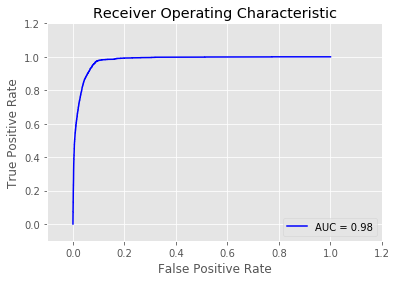

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.940287	valid's auc: 0.946102
[100]	train's auc: 0.952543	valid's auc: 0.956705
[150]	train's auc: 0.955865	valid's auc: 0.954936
[200]	train's auc: 0.959045	valid's auc: 0.95638
[250]	train's auc: 0.962901	valid's auc: 0.959627
[300]	train's auc: 0.969549	valid's auc: 0.967563
[350]	train's auc: 0.973677	valid's auc: 0.969615
[400]	train's auc: 0.97756	valid's auc: 0.973852
[450]	train's auc: 0.979736	valid's auc: 0.975857
[500]	train's auc: 0.981018	valid's auc: 0.976177
[550]	train's auc: 0.981801	valid's auc: 0.976178
[600]	train's auc: 0.982446	valid's auc: 0.977099
[650]	train's auc: 0.98315	valid's auc: 0.977117
[700]	train's auc: 0.983456	valid's auc: 0.977593
[750]	train's auc: 0.983926	valid's auc: 0.978007
[800]	train's auc: 0.984289	valid's auc: 0.977955
[850]	train's auc: 0.984773	valid's auc: 0.978347
[900]	train's auc: 0.985176	valid's auc: 0.978823
[950]	train

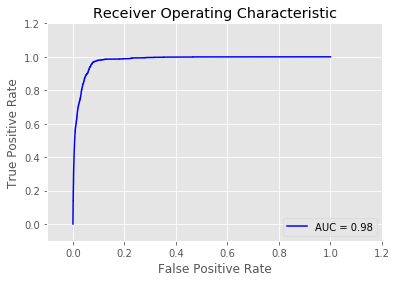

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.94097	valid's auc: 0.947389
[100]	train's auc: 0.955008	valid's auc: 0.957876
[150]	train's auc: 0.959082	valid's auc: 0.957402
[200]	train's auc: 0.960494	valid's auc: 0.958605
[250]	train's auc: 0.965442	valid's auc: 0.961392
[300]	train's auc: 0.97088	valid's auc: 0.968251
[350]	train's auc: 0.973962	valid's auc: 0.97186
[400]	train's auc: 0.977738	valid's auc: 0.97481
[450]	train's auc: 0.97961	valid's auc: 0.976967
[500]	train's auc: 0.980542	valid's auc: 0.977835
[550]	train's auc: 0.981289	valid's auc: 0.978149
[600]	train's auc: 0.981749	valid's auc: 0.978064
[650]	train's auc: 0.982478	valid's auc: 0.978246
[700]	train's auc: 0.98296	valid's auc: 0.978548
[750]	train's auc: 0.983228	valid's auc: 0.978481
[800]	train's auc: 0.983767	valid's auc: 0.978741
[850]	train's auc: 0.984217	valid's auc: 0.978901
[900]	train's auc: 0.984602	valid's auc: 0.978976
[950]	train's 

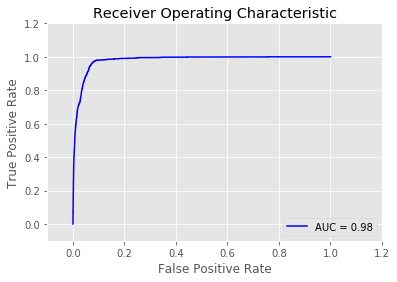

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.92892	valid's auc: 0.908312
[100]	train's auc: 0.953087	valid's auc: 0.937236
[150]	train's auc: 0.957493	valid's auc: 0.943943
[200]	train's auc: 0.961352	valid's auc: 0.949015
[250]	train's auc: 0.968156	valid's auc: 0.957042
[300]	train's auc: 0.972121	valid's auc: 0.964032
[350]	train's auc: 0.974158	valid's auc: 0.967201
[400]	train's auc: 0.977632	valid's auc: 0.972323
[450]	train's auc: 0.980759	valid's auc: 0.977158
[500]	train's auc: 0.981809	valid's auc: 0.978285
[550]	train's auc: 0.98215	valid's auc: 0.978592
[600]	train's auc: 0.982699	valid's auc: 0.979085
[650]	train's auc: 0.983173	valid's auc: 0.979548
[700]	train's auc: 0.98343	valid's auc: 0.979879
[750]	train's auc: 0.984013	valid's auc: 0.980092
[800]	train's auc: 0.984261	valid's auc: 0.980342
[850]	train's auc: 0.98488	valid's auc: 0.980766
[900]	train's auc: 0.985271	valid's auc: 0.980842
[950]	train'

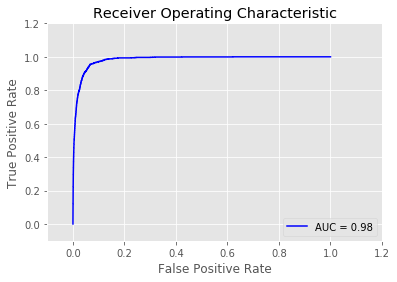

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.939522	valid's auc: 0.915435
[100]	train's auc: 0.957036	valid's auc: 0.941834
[150]	train's auc: 0.961494	valid's auc: 0.946925
[200]	train's auc: 0.965614	valid's auc: 0.951259
[250]	train's auc: 0.967104	valid's auc: 0.954575
[300]	train's auc: 0.970854	valid's auc: 0.961776
[350]	train's auc: 0.974496	valid's auc: 0.966879
[400]	train's auc: 0.977256	valid's auc: 0.970897
[450]	train's auc: 0.979736	valid's auc: 0.975146
[500]	train's auc: 0.98094	valid's auc: 0.977066
[550]	train's auc: 0.981983	valid's auc: 0.978232
[600]	train's auc: 0.982387	valid's auc: 0.978595
[650]	train's auc: 0.982997	valid's auc: 0.979468
[700]	train's auc: 0.983484	valid's auc: 0.97999
[750]	train's auc: 0.983815	valid's auc: 0.980072
[800]	train's auc: 0.984336	valid's auc: 0.980447
[850]	train's auc: 0.984623	valid's auc: 0.980377
[900]	train's auc: 0.985162	valid's auc: 0.980579
[950]	trai

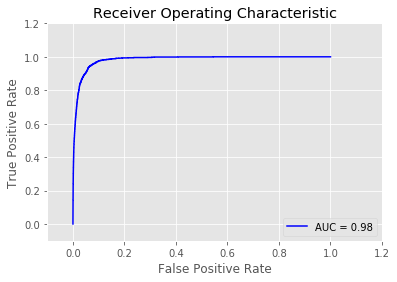

preparing validation datasets
Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.922751	valid's auc: 0.903005
[100]	train's auc: 0.954955	valid's auc: 0.941535
[150]	train's auc: 0.96141	valid's auc: 0.948763
[200]	train's auc: 0.964762	valid's auc: 0.954119
[250]	train's auc: 0.964181	valid's auc: 0.957198
[300]	train's auc: 0.968808	valid's auc: 0.962446
[350]	train's auc: 0.972781	valid's auc: 0.967854
[400]	train's auc: 0.976025	valid's auc: 0.972474
[450]	train's auc: 0.978809	valid's auc: 0.975981
[500]	train's auc: 0.980133	valid's auc: 0.977958
[550]	train's auc: 0.981125	valid's auc: 0.9788
[600]	train's auc: 0.981589	valid's auc: 0.979193
[650]	train's auc: 0.982193	valid's auc: 0.979667
[700]	train's auc: 0.982724	valid's auc: 0.979966
[750]	train's auc: 0.983256	valid's auc: 0.980351
[800]	train's auc: 0.983525	valid's auc: 0.980384
[850]	train's auc: 0.983976	valid's auc: 0.980852
[900]	train's auc: 0.984532	valid's auc: 0.981135
[950]	train

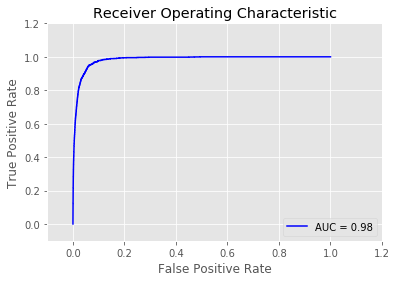

In [109]:
pos_model_list  =[]
neg_model_list  =[]
score_posA = []
score_negA = []

for idx in range(0,15):
    fold_id = idx//3
    Train_DataSet = train_df[train_df.index.isin(list(all_list - DateFold[fold_id]))].reset_index(drop=True)
    Normal_DF = Train_DataSet[Train_DataSet['label']==0]
    Fraud_DF = Train_DataSet[Train_DataSet['label']==1]
    
    number_record_fraud = len(Fraud_DF)
    number_record_normal = len(Normal_DF)
    #undersample
    random_normal_indices = np.array(np.random.choice(Normal_DF.index,number_record_fraud,replace=False))
    filter_list = list(random_normal_indices) + list(Fraud_DF.index)
    under_sample_train = Train_DataSet[Train_DataSet.index.isin(filter_list)].reset_index(drop=True)

    
    Val_DataSet = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)
    model_neg,score_neg = model_validation(under_sample_train,Val_DataSet,predictors,'Fraud',{})    
    neg_model_list.append(model_neg)    
    score_negA.append(score_neg)

In [ ]:
import joblib
#joblib.dump(pos_model_list,'./pos_model_list.dat')
#joblib.dump(score_posA,'./score_pos.dat')
#joblib.dump(neg_model_list,'./neg_model_list.dat')
#joblib.dump(score_negA,'./score_neg.dat')

In [110]:
val_df = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)

val_r_pos=pd.DataFrame()
val_r_neg=pd.DataFrame()

for idx in tqdm(range(0,len(neg_model_list))):
    #model_pos = pos_model_list[idx]
    model_neg = neg_model_list[idx]
    #val_pos = model_pos.predict(val_df[predictors],num_iteration=model_pos.best_iteration)
    val_neg = model_neg.predict(val_df[predictors],num_iteration=model_neg.best_iteration)
    #val_r_pos[idx] = 1 - val_pos
    val_r_neg[idx] = val_neg

100%|██████████| 15/15 [01:20<00:00,  5.36s/it]


In [111]:
#pos_mean = val_r_pos.mean(axis=1)
neg_mean = val_r_neg.mean(axis=1)

Ant-Score: 0.4373692077727952


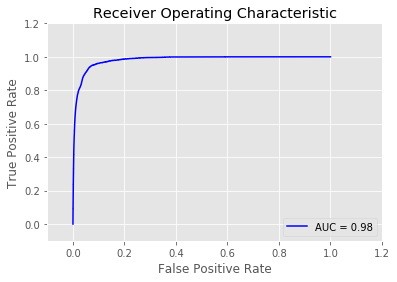

In [112]:
_,_,_ = atecml.data.accuracy_validation(val_df['Fraud'],neg_mean)

In [65]:
test_df = pd.read_pickle('./01_test.dat')
test_r_pos=pd.DataFrame()
test_r_neg=pd.DataFrame()

for idx in tqdm(range(0,len(neg_model_list))):
    #model_pos = pos_model_list[idx]
    model_neg = neg_model_list[idx]
    #test_pos = model_pos.predict(test_df[predictors],num_iteration=model_pos.best_iteration)
    test_neg = model_neg.predict(test_df[predictors],num_iteration=model_neg.best_iteration)
    #test_r_pos[idx] = 1 - test_pos
    test_r_neg[idx] = test_neg
neg_mean = test_r_neg.mean(axis=1)    
result=pd.DataFrame()
result['id'] = test_df['id']
result['score'] = neg_mean
result[['id','score']].to_csv('./submit_2018_07_06_01.csv',index=False)

100%|██████████| 5/5 [01:00<00:00, 12.01s/it]
